# Решаем задачу классификации изображений животных по их типу.

Задача классификации изображений - одна из классических задач компьютерного зрения, которая не теряет своей актуальности, поскольку в различных приложениях и сервисах требуется классифицировать объекты, изображенные на фотографии (определение пользователя, марки машины и т.д.).

### План работы:
- Разведочный анализ и первичиная аналитика данных
- Очистка данных - укрупнение категорий, удаление неподходящих элементов и т.д. (при необходимости)



**Key files to be uploaded:**

In [ ]:
'''
sift_data_reduced2.csv
sift_data_labels2.csv
sift_scaler2.pkl
sift_pca2.pkl
model_svc_sift_proba2.pkl

hog_data_reduced2.csv
hog_data_labels2.csv
hog_scaler2.pkl
hog_pca2.pkl
svm_model_hogs2.pkl

class_to_idx.json

resnet50_state_dict.pth
vit_base_patch32_state_dict.pth
'''

# **EDA SECTION** (please refer to presentation for details)

In [ ]:
# pip freeze > requirements.txt

In [2]:
# основные библиотеки
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch


from PIL import Image
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [120]:
# расположение датасета (предплологается что он в 1 папке с nootebook)
main_path = 'Data/'

RANDOM = 12345

In [121]:
# просмотр всех категорий папок в каталоге
%pwd
content_file = os.listdir(main_path)
print(content_file)
print(F'\nКол-во категорий: {len(content_file)}')

['Bear', 'Brown bear', 'Bull', 'Camel', 'Canary', 'Cat', 'Caterpillar', 'Cattle', 'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise', 'Turkey', 'Turtle', 'Whale', 'Woodpecker', 'Worm', 'Zebra']

Кол-во категорий: 81


In [122]:
# создадим датасет для записи информации
columns = ['name_image', 'category', 'path_to_image', ]
data = pd.DataFrame(columns = columns)

for i in content_file:
    #вытаскиваем фалй из каждой папки
    content_folder = os.listdir(main_path + i)
    
    #сохраняем название картинок в датасет
    data_l = pd.DataFrame(content_folder, columns = ['name_image'])
    #сохраняем категорию картинок
    data_l['category'] = i
    #сохраняем путь до картинки
    data_l['path_to_image'] = [main_path+i+'/'+x for x in data_l['name_image']]
    
    #объеденям датасеты
    data = pd.concat([data, data_l], axis = 0, ignore_index = True)
    
    #очищаем память
    del data_l

In [123]:
# просмотр датасета
data

,name_image,category,path_to_image
0,0155b267ade95d1e.jpg,Bear,Data/Bear/0155b267ade95d1e.jpg
1,01650042709e7a82.jpg,Bear,Data/Bear/01650042709e7a82.jpg
2,02d4376234375c2f.jpg,Bear,Data/Bear/02d4376234375c2f.jpg
3,02f783a758aec795.jpg,Bear,Data/Bear/02f783a758aec795.jpg
4,0312356c607c20dc.jpg,Bear,Data/Bear/0312356c607c20dc.jpg
...,...,...,...
55214,f65b1055295737d6.jpg,Zebra,Data/Zebra/f65b1055295737d6.jpg
55215,f6ff44677fa59c40.jpg,Zebra,Data/Zebra/f6ff44677fa59c40.jpg
55216,f8fe90d00e670410.jpg,Zebra,Data/Zebra/f8fe90d00e670410.jpg
55217,fb2fc22e1e8d94b7.jpg,Zebra,Data/Zebra/fb2fc22e1e8d94b7.jpg


In [124]:
# информация в датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55219 entries, 0 to 55218
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name_image     55219 non-null  object
 1   category       55219 non-null  object
 2   path_to_image  55219 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [ ]:
# поиск среднего и стандартного отклонения набора данных изображений

# 1) Создание класса для pytorch
class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data.path_to_image[index]
        image = Image.open(image_path)
        label = self.data.category[index]
        if self.transform:
            image = self.transform(image)
        return image, label

# Определение трансформаций 
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3]), # берём только первые 3 канала (RGB), т.к. есть изображения с alpha-каналом (4 канала)
    #transforms.Normalize(mean=[0.2174, 0.2132, 0.1873], # Наши подсчитанные значения mean и std для нормализации
    #                     std=[0.3009, 0.2922, 0.2767])
])
    

In [ ]:
%%time

# 2) Создание DataLoader объекта и вычисление total_sum и total_sum_square


dataset = MyDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)



total_sum = torch.tensor([0.0, 0.0, 0.0])
total_sum_square = torch.tensor([0.0, 0.0, 0.0])

sizes_df = pd.DataFrame(columns=['id', 'width', 'height'])

i = 0

for img, _ in dataloader:
    total_sum += img.sum(axis = [0, 2, 3])
    total_sum_square += (img ** 2).sum(axis = [0, 2, 3])

    # add images width and height to df
    sizes_df.loc[len(sizes_df)] = [i, img[0].size()[1], img[0].size()[2]]

    i += 1
    if i % 5000 == 0:
        print(f'Осталось загрузить: {len(data) - i} картинки')

    

#sizes_df



In [ ]:
# проверка значений
total_sum
# tensor([1.2005e+10, 1.1772e+10, 1.0342e+10])

In [ ]:
# проверка значений
total_sum_square
# tensor([7.6080e+09, 7.2253e+09, 6.1638e+09])

In [ ]:
# calculate sum of all dots
sizes_df['res'] = sizes_df['width'] * sizes_df['height']

count = sizes_df['res'].sum()
total_mean = total_sum / count
total_var = (total_sum_square / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)

print('mean: ' + str(total_mean)) # mean: tensor([0.4817, 0.4724, 0.4150])
print('std:: ' + str(total_std)) # std.: tensor([0.2707, 0.2584, 0.2741])


**Средние значения и дисперсия посчитаны по каждому из RGB - каналов:** <br>
mean: tensor([0.4817, 0.4724, 0.4150]) <br>
std:: tensor([0.2707, 0.2584, 0.2741]) <br>

С помощью этих значений мы можем нормализовать датасет:

In [ ]:
# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.ToTensor(), # new line, to check!!!
    transforms.Normalize(mean=[0.4817, 0.4724, 0.4150], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2707, 0.2584, 0.2741]), 
    #transforms.Grayscale(1)  # new line, to check!!!
])

dataset_norm = MyDataset(data, transform=transform_norm)

Датасет нормализован

Категория: Bear
Имя картинки: 0e656ab17f715b23.jpg


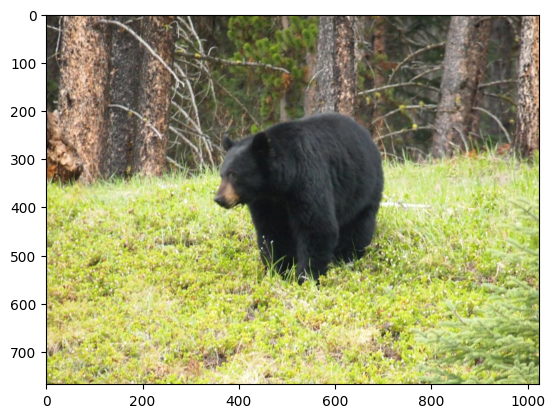

Категория: Canary
Имя картинки: 07bfc01d058f6feb.jpg


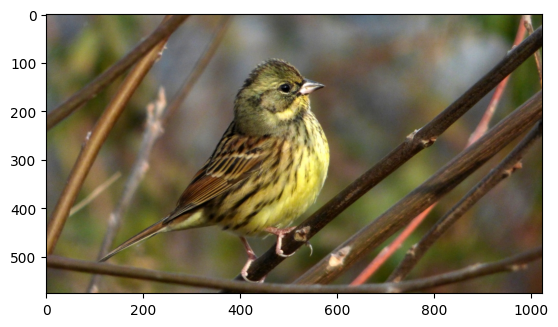

Категория: Moths and butterflies
Имя картинки: OIP-aduF9xe12paXmuMUfAVR1wHaGL.jpeg


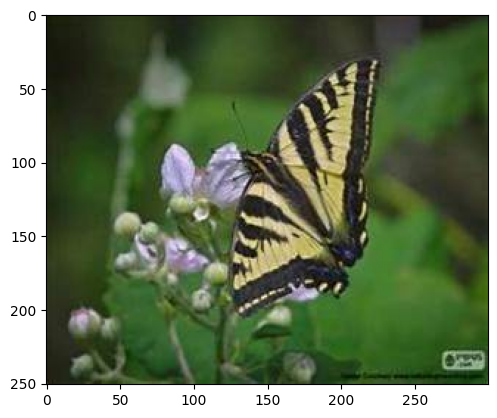

Категория: Spider
Имя картинки: OIP-Xw5qBiT89G4S3828NexwogHaHa.jpeg


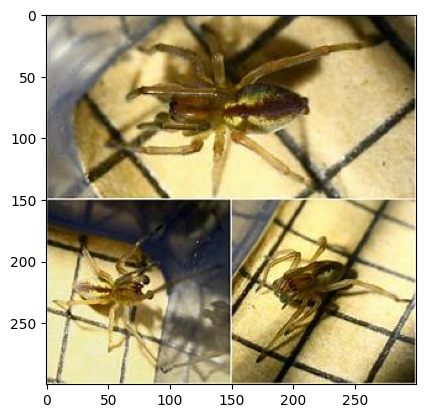

Категория: Horse
Имя картинки: OIP-K6Z0bhFddwM2LUnbhiYbzgHaEu.jpeg


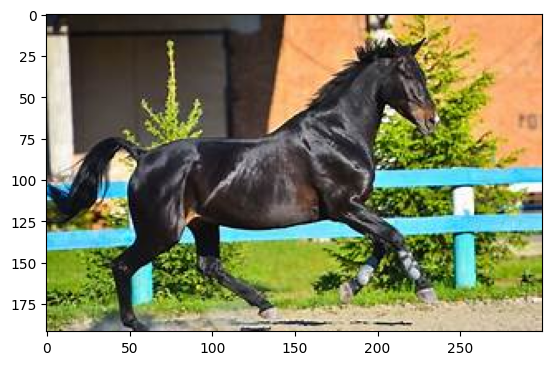

In [ ]:
# проверка на просмотр картинки при помощи датасета
chek = [20,467,34270, 50000, 24045]

for i in chek:
    #Обозначение категории и названия картинки
    print('Категория:', data['category'][i])
    print('Имя картинки:', data['name_image'][i])
    
    #вывод изображения
    plt.imshow(Image.open(data['path_to_image'][i]))
    plt.show()

In [ ]:
# сводная таблица для просмотра распределения
# 'name_image' в качестве заглушки для подсчета кол-ва
group_category = data.groupby('category').agg({'name_image':'count'})\
                        .sort_values('name_image', ascending = False)

In [ ]:
# 20 самых больших категорий
group_category.head(20)

,name_image
category,
Spider,5883
Moths and butterflies,5613
Dog,4863
Chicken,3661
Horse,3166
Squirrel,2297
Cattle,2107
Sheep,1993
Cat,1668


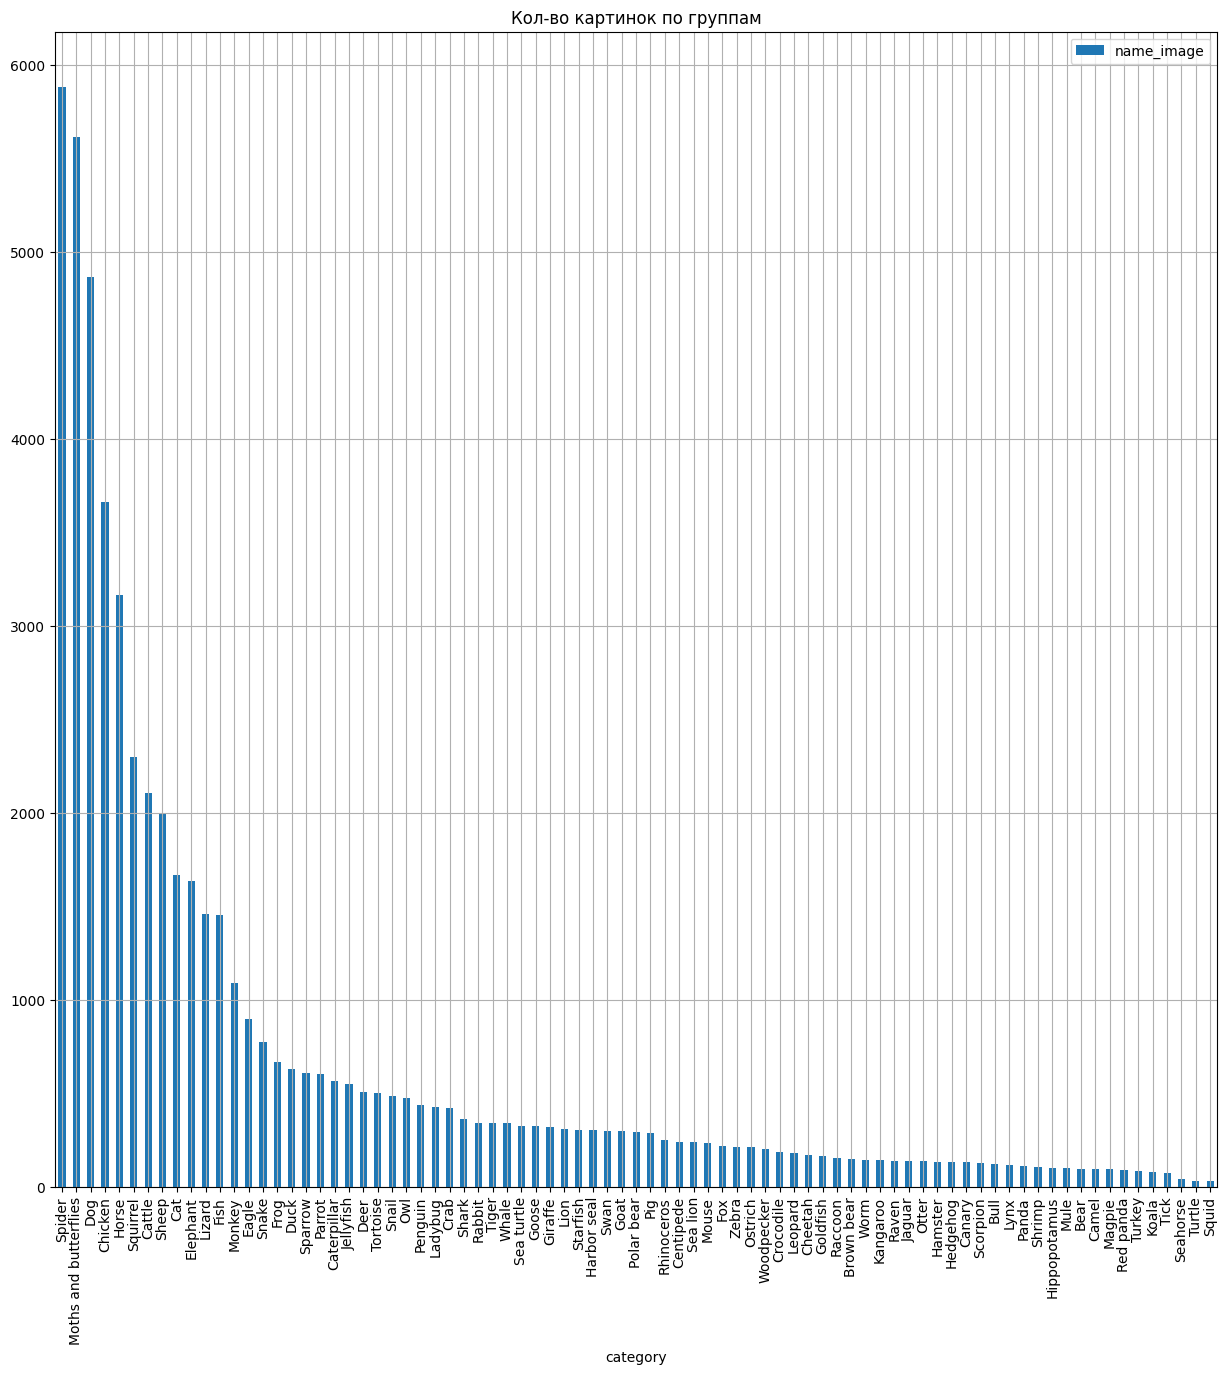

In [ ]:
# построим график расперделения
group_category.plot(kind = 'bar', title = 'Кол-во картинок по группам', 
                                                    grid = True, figsize = (15,15))
plt.xticks(rotation=90)
plt.show()

**Вывод:** 
Всего 81 категория и 55219 картинок. <br>
Топ 5 по количеству картинок это категории Spider, Moths and butterflies, Dog, Chicken, Horse. <br>
Выявлен дисбаланс в распределении категорий картинок (отчасти связанный с тем, что мы скомбинироавали 2 датасета в один, но на начальной стадии больше = лучше :) <br>
Предложение - удалить/переместить последние 20-30 категорий, урезать картинки у топ 10 по распределению и дополнить картинки в оставшиеся категории для примемлемого уровня баланса.

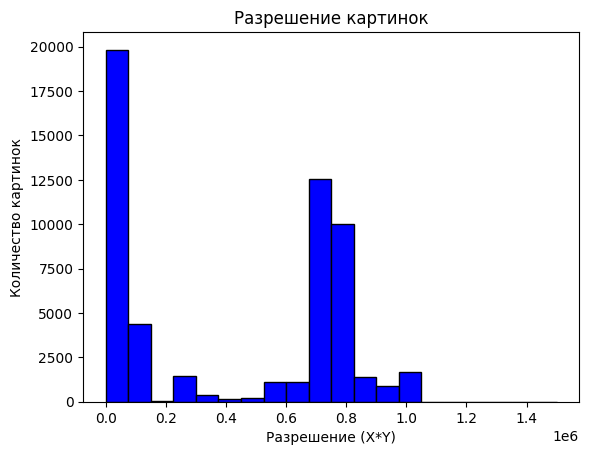

In [ ]:
# Анализ разрешений картинок в датасете

plt.hist(sizes_df['res'], bins = 20, color='blue', edgecolor='black', range = [0, 1500000])

plt.xlabel('Разрешение (X*Y)')
plt.ylabel('Количество картинок')
plt.title(f'Разрешение картинок')

# Show the plot
plt.show()


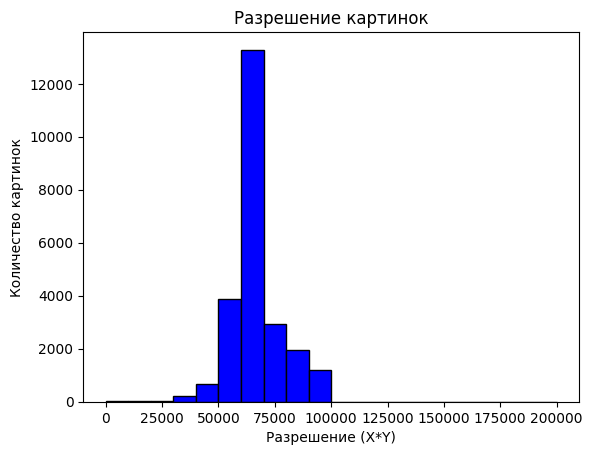

In [ ]:
# Анализ разрешений картинок в датасете (нижняя часть распределения)
plt.hist(sizes_df['res'], bins = 20, color='blue', edgecolor='black', range = [0, 200000])

plt.xlabel('Разрешение (X*Y)')
plt.ylabel('Количество картинок')
plt.title(f'Разрешение картинок')

# Show the plot
plt.show()

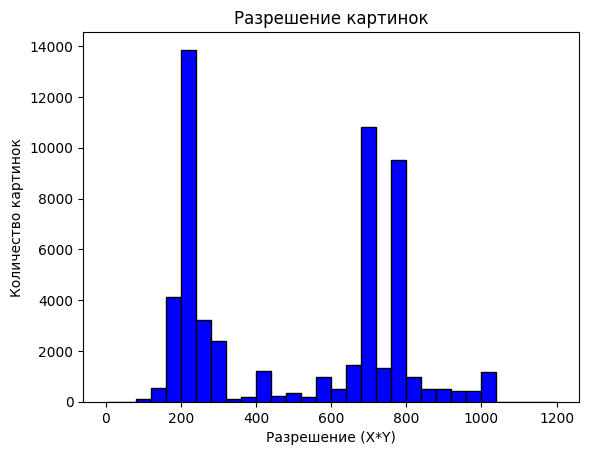

In [ ]:
# Анализ разрешений картинок в датасете (наименьшее измерение)
sizes_df['min'] = sizes_df[['width', 'height']].min(axis=1)

plt.hist(sizes_df['min'] , bins = 30, color='blue', edgecolor='black', range = [0, 1200])

plt.xlabel('Разрешение по наименьшему измерению')
plt.ylabel('Количество картинок')
plt.title(f'Разрешение картинок')

# Show the plot
plt.show()



In [ ]:
# механизм деления на тренировочную и тестовую выборку

# аналогично с записям картинок в датасет data, только грузим по отдельности
columns = ['name_image', 'category', 'path_to_image', ]
train = pd.DataFrame(columns = columns)
test = pd.DataFrame(columns = columns)

for i in content_file:
    #дробим картинки по отдельности для каждой категории
    train_l, test_l = train_test_split(data.loc[data['category'] == i], test_size = 0.3, random_state = RANDOM)
    
    #записываем результаты
    train = pd.concat([train, train_l], axis = 0, ignore_index = True)
    test = pd.concat([test, test_l], axis = 0, ignore_index = True)
    
    del train_l, test_l

In [ ]:
# проверка
print(train.shape, test.shape)

(38615, 3) (16604, 3)


In [ ]:
# проверка на корректность деления 
group_category_train = train.groupby('category').agg({'name_image':'count'})\
                        .sort_values('name_image', ascending = False)

group_category_test = test.groupby('category').agg({'name_image':'count'})\
                        .sort_values('name_image', ascending = False)

In [ ]:
group_category_train.head(10)


,name_image
category,
Spider,4118
Moths and butterflies,3929
Dog,3404
Chicken,2562
Horse,2216
Squirrel,1607
Cattle,1474
Sheep,1395
Cat,1167


In [ ]:
group_category_test.head(10)

,name_image
category,
Spider,1765
Moths and butterflies,1684
Dog,1459
Chicken,1099
Horse,950
Squirrel,690
Cattle,633
Sheep,598
Cat,501


**Вывод:** Датасет поделился корректно по каждой категории по отдельности.

# **RESIZING AND NORMALIZING IMAGES**

## P1 - resizing

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import cv2
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# расположение датасета (предплологается что он в 1 папке с nootebook)
# main_path = 'Data/'
main_path = 'Data_small/'

RANDOM = 12345

In [3]:
# просмотр всех категорий папок в каталоге
%pwd
content_file = os.listdir(main_path)
print(content_file)
print(F'\nКол-во категорий: {len(content_file)}')

['Bear', 'Brown bear', 'Bull', 'Camel', 'Canary', 'Cat', 'Caterpillar', 'Cattle', 'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise', 'Turkey', 'Turtle', 'Whale', 'Woodpecker', 'Worm', 'Zebra']

Кол-во категорий: 81


In [4]:
# создадим датасет для записи информации
columns = ['name_image', 'category', 'path_to_image', ]
data = pd.DataFrame(columns = columns)

for i in content_file:
    #вытаскиваем фалй из каждой папки
    content_folder = os.listdir(main_path + i)
    
    #сохраняем название картинок в датасет
    data_l = pd.DataFrame(content_folder, columns = ['name_image'])
    #сохраняем категорию картинок
    data_l['category'] = i
    #сохраняем путь до картинки
    data_l['path_to_image'] = [main_path+i+'/'+x for x in data_l['name_image']]
    
    #объеденям датасеты
    data = pd.concat([data, data_l], axis = 0, ignore_index = True)
    
    #очищаем память
    del data_l

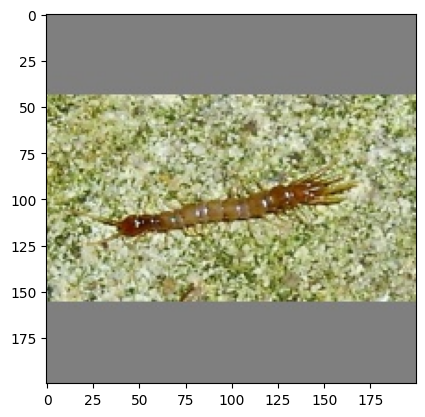

In [5]:
img = data['path_to_image'][5000]
plt.imshow(Image.open(img))
plt.show()

In [39]:
new_folder_name = 'Data_small'
img_path = data['path_to_image'][5000]
img_path_new = new_folder_name + img_path[4:]
print(img_path_new)

Data_small/Centipede/34cb8e39b51b7046.jpg


In [10]:

def resizeAndPad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size
  # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC
# aspect ratio of image
    aspect = w/h
# compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0
    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3
    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
        pad_left, pad_right, borderType=cv2.BORDER_CONSTANT,  
        value=padColor)
    return scaled_img

In [34]:
img2 = cv2.imread(img)
img2 = img2.copy()

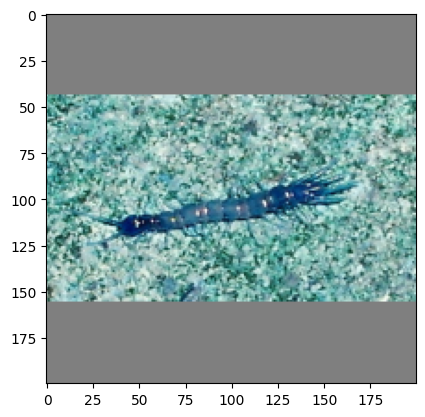

In [35]:
new_img = resizeAndPad(img2, (200,200), 127)
#i = plt.imshow(new_img, cmap='grey')
new_img.shape
# Saving the new image inside DATA folder
filename = 'resized_test1.jpg'  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, new_img)

plt.imshow(new_img)
plt.show()

In [58]:
original_string = "example/text/before/last/slash"
original_string.rpartition("/")[0]

'example/text/before/last'

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# поиск среднего и стандартного отклонения набора данных изображений

# 1) Создание класса для pytorch
class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        #image_path = self.data.path_to_image[index]
        image_path = self.data['path_to_image'][index]
        #path_to_image = self.data.path_to_image[index] # test
        image = Image.open(image_path)
        label = self.data['category'][index]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path

# Определение трансформаций 
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3]), # берём только первые 3 канала (RGB), т.к. есть изображения с alpha-каналом (4 канала)
    #transforms.Normalize(mean=[0.2174, 0.2132, 0.1873], # Наши подсчитанные значения mean и std для нормализации
    #                     std=[0.3009, 0.2922, 0.2767])
])
    

In [31]:
# 2) Создание DataLoader объекта и вычисление total_sum и total_sum_square


dataset = MyDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

total_sum = torch.tensor([0.0, 0.0, 0.0])
total_sum_square = torch.tensor([0.0, 0.0, 0.0])

sizes_df = pd.DataFrame(columns=['id', 'width', 'height'])

i = 0

for img, _, _ in dataloader:
    total_sum += img.sum(axis = [0, 2, 3])
    total_sum_square += (img ** 2).sum(axis = [0, 2, 3])

    # add images width and height to df
    sizes_df.loc[len(sizes_df)] = [i, img[0].size()[1], img[0].size()[2]]

    i += 1
    if i % 5000 == 0:
        print(f'Осталось загрузить: {len(data) - i} картинки')

Осталось загрузить: 8726 картинки
Осталось загрузить: 3726 картинки


In [32]:
# calculate sum of all dots
sizes_df['res'] = sizes_df['width'] * sizes_df['height']

count = sizes_df['res'].sum()
total_mean = total_sum / count
total_var = (total_sum_square / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)

print('mean: ' + str(total_mean)) # mean: tensor([0.5018, 0.4925, 0.4460])
print('std:: ' + str(total_std)) # std.: tensor([0.2339, 0.2276, 0.2402]))

mean: tensor([0.5018, 0.4925, 0.4460])
std:: tensor([0.2339, 0.2276, 0.2402])


In [7]:
# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = MyDataset(data, transform=transform_norm)

In [65]:
from tqdm import tqdm  # Import tqdm for the progress bar

new_folder_name = 'Data_small'
img_shape = (200, 200)


img_count_to_resize = len(data)

for i in tqdm(range(img_count_to_resize), desc="Resizing images"):
    img_path = data['path_to_image'][i]
    img_temp = cv2.imread(img_path)
    img_temp = img_temp.copy()
    new_img = resizeAndPad(img_temp, img_shape, 127)

    img_path_new = new_folder_name + img_path[4:]
    img_folder = img_path_new.rpartition("/")[0]
    
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
    
    cv2.imwrite(str(img_path_new), new_img)
    

len(data)

Resizing images: 100%|██████████| 55219/55219 [29:12<00:00, 31.50it/s]  


55219

## P2 - normalizing

In [9]:
# Save normalized images
import pathlib
from tqdm import tqdm  # Import tqdm for the progress bar
img = dataset_norm[0][0]

new_folder = 'Data_small_normalized'
old_folder = 'Data_small'


# Output (display or save) the image
#img.show()  # Display the image
#img.save("output_image.jpg")  # Save the image to a file

for i in tqdm(range(len(dataset_norm)), desc = "Saving normalized images"):
        try: 
                img = dataset_norm[i][0]
                img = transforms.ToPILImage()(img.squeeze(0))  # Convert the Tensor back to a PIL Image

                addr = dataset_norm[i][2]
                addr_right = addr[len(old_folder):]
                addr_new = new_folder  + addr_right
                folder = addr_new.rpartition('/')[0]

                if not os.path.exists(folder):
                        os.makedirs(folder)
                img.save(addr_new)  # Save the image to a file
        except:
                pass




Saving normalized images: 100%|██████████| 55219/55219 [02:14<00:00, 409.78it/s]


# **SIFT SECTION**

## P1 - preparing SIFT keypoints

In [34]:
# DEFINE SIFT FUNCTIONS
import cv2
import os
import pathlib
from tqdm import tqdm
import numpy as np


dataset_directory = 'Data_small_normalized_adj' # Smaller dataset for SIFT section

# Function to extract SIFT features from an image
def extract_sift_features(image_path, max_descriptors=100):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute key points and descriptors
    key_points, descriptors = sift.detectAndCompute(img, None)

    if key_points is not None and descriptors is not None:

        # Ensure that all descriptors have the same length (pad or truncate)
        if len(descriptors) < max_descriptors:
            descriptors = np.vstack([descriptors, np.zeros((max_descriptors - len(descriptors), descriptors.shape[1]))])
        elif len(descriptors) > max_descriptors:
            descriptors = descriptors[:max_descriptors, :]

        return key_points, descriptors
    
    else:
        return None, None


# Function to draw SIFT keypoints on an image
def draw_sift_keypoints(image_path, key_points):
    # Read the image
    img = cv2.imread(image_path)

    # Draw the keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, key_points, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the image with keypoints
    cv2.imshow('Image with SIFT Keypoints', img_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [35]:
# RUN EXTRACT SIFT FEATURES

image_descriptors = []
image_labels = []

dir_progress = tqdm(desc="Processing Directories", unit="dir")

for root, dirs, files in os.walk(dataset_directory):
    # Update the directory progress bar
    dir_progress.update(1)

    for file in tqdm(files, desc="Preparing SIFT"):
        # Check if the file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Construct the full path to the image
            image_path = os.path.join(root, file)

            # Extract SIFT features
            key_points, descriptors = extract_sift_features(image_path)
            if key_points is not None and descriptors is not None:
                image_descriptors.append(descriptors)

                # add label
                label = root.rpartition(pathlib.os.sep)[2]
                image_labels.append(label)
                
dir_progress.close()

Preparing SIFT: 0it [00:00, ?it/s]0, ?dir/s]
Preparing SIFT: 100%|██████████| 339/339 [00:13<00:00, 25.47it/s]
Processing Directories: 21dir [09:30, 27.15s/dir]


In [6]:
# Draw and display SIFT keypoints on the image
draw_sift_keypoints(image_path, key_points) # USEFUL OUTPUT!!!

In [36]:
print(len(image_descriptors))
print(len(image_labels))

22476
22476


In [37]:
# normalize SIFT descriptors and reduce dim using PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Reshape descriptors to have a consistent shape
image_descriptors_same = np.array(image_descriptors)
image_descriptors_same = image_descriptors_same.reshape(image_descriptors_same.shape[0], -1)

df = pd.DataFrame(image_descriptors_same)
df.to_csv('sift_data2.csv', index=False, header=False)

In [38]:
labels_df = pd.DataFrame(image_labels)
labels_df.to_csv('sift_data_labels2.csv', index=False, header=False)

### Mutiprocessing to do SIFT (not in use)

In [3]:
'''
import multiprocessing
import pathlib

def process_images_batch(image_paths):
    batch_descriptors = []
    batch_labels = []

    for image_path in tqdm(image_paths, desc="Preparing SIFT"):
        key_points, descriptors = extract_sift_features(image_path)
        if key_points is not None and descriptors is not None:
            batch_descriptors.append(descriptors)
            label = pathlib.Path(image_path).parent.name
            batch_labels.append(label)

    return batch_descriptors, batch_labels

def get_image_paths(dataset_directory):
    image_paths = []
    for root, dirs, files in os.walk(dataset_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

# Main Code
dataset_directory = 'Data_small_normalized'
image_paths = get_image_paths(dataset_directory)

# Split image paths into batches for parallel processing
n_processes = multiprocessing.cpu_count()
print('Number of processes: ', n_processes)
batch_size = len(image_paths) // n_processes
image_batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

# Process in parallel
pool = multiprocessing.Pool(processes=n_processes)
results = pool.map(process_images_batch, image_batches)

# Using tqdm to track the progress of batch completion
for _ in tqdm(pool.imap_unordered(process_images_batch, image_batches), total=len(image_batches), desc="Processing Batches"):
    results.append(_)

# Combine results from all batches
image_descriptors = []
image_labels = []
for descriptors, labels in results:
    image_descriptors.extend(descriptors)
    image_labels.extend(labels)

pool.close()
pool.join()
'''

Number of processes:  32


## P2 - load sift data from csv and scale + apply pca

In [39]:
df = pd.read_csv('sift_data2.csv', header=None)
image_descriptors_same = df.values


In [40]:
image_labels_sift = pd.read_csv('sift_data_labels2.csv', header=None)
image_labels_sift = image_labels_sift.values

In [41]:
# Double-check dimensions
print(f'data_shape:\t{image_descriptors_same.shape}')
print(f'labels_shape:\t{image_labels_sift.shape}')

data_shape:	(22476, 12800)
labels_shape:	(22476, 1)


In [42]:
# Normalize the feature vectors
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(image_descriptors_same)

with open('sift_scaler2.pkl', 'wb') as file:
    pickle.dump(scaler, file)
normalized_descriptors = scaler.transform(image_descriptors_same)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=30)  # Adjust the number of components as needed (was 50)
pca.fit(normalized_descriptors)

with open('sift_pca2.pkl', 'wb') as file:
    pickle.dump(pca, file)
reduced_descriptors = pca.transform(normalized_descriptors)


In [43]:
# Double-check dimensions
print(f'data_shape:\t{reduced_descriptors.shape}')
print(f'labels_shape:\t{image_labels_sift.shape}')

data_shape:	(22476, 30)
labels_shape:	(22476, 1)


In [44]:
# Save reduced descriptors to csv
df = pd.DataFrame(reduced_descriptors)
df.to_csv('sift_data_reduced2.csv', index=False, header=False)

In [ ]:
# files needed:
# sift_data_reduced.csv
# sift_data_labels.csv
# sift_scaler.pkl
# sift_pca.pkl

## P3 - load sift data and train SVC model

In [45]:
reduced_descriptors = pd.read_csv('sift_data_reduced2.csv', header=None)
reduced_descriptors = reduced_descriptors.values
reduced_descriptors.shape

(22476, 30)

In [46]:
from  sklearn.model_selection import train_test_split 

X_features = reduced_descriptors
X_train, X_test, Y_train, Y_test = train_test_split(X_features, image_labels_sift, test_size = 0.3, random_state = 12345, stratify = image_labels_sift)

In [50]:
# Train and save model
from  sklearn.svm import SVC
import pickle

#model_svc_sift = SVC(verbose=True, kernel='rbf', random_state=12345)
model_svc_sift = SVC(verbose=True, kernel='rbf', random_state=12345, probability=True) # try fitting SVC with probability=True

Y_train = Y_train.ravel() # flatten Y_train
Y_test = Y_test.ravel() # flatten Y_test

model_svc_sift.fit(X_train, Y_train)
filename = 'model_svc_sift_proba2.pkl'

pickle.dump(model_svc_sift, open(filename, 'wb'))
print("score on training set params: ", model_svc_sift.score(X_train, Y_train))
print("score on testing set params: ", model_svc_sift.score(X_test, Y_test))

[LibSVM]score on training set params:  0.3394139706349711
score on testing set params:  0.2389144297790301


In [48]:
# Load model
#with open('model_svc_sift.pkl', 'rb') as file:
with open('model_svc_sift_proba2.pkl', 'rb') as file:
    model_svc_sift = pickle.load(file)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model_svc_sift.predict(X_test)
predicted_labels = y_pred
true_labels = Y_test
    
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.2389144297790301
Precision: 0.17420652726576463
Recall: 0.2389144297790301
F1 Score: 0.16023465873391157


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# files needed:
# sift_data_reduced.csv
# sift_data_labels.csv
# sift_scaler.pkl
# sift_pca.pkl
# model_svc_sift_proba.pkl

### GridSearch CV testing

In [55]:
from  sklearn.svm import SVC
from  sklearn.model_selection import train_test_split 
import pickle

from sklearn.model_selection import GridSearchCV

X_features = reduced_descriptors
X_train, X_test, Y_train, Y_test = train_test_split(X_features, image_labels, test_size = 0.3, random_state = 12345, stratify = image_labels)



'''
param_grid = {
    'C': [10],
    'kernel': ['linear'],
    'gamma': ['scale'],
}

'''
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [1, 'scale', 'auto'],
    'degree': [2, 4]
}


grid_search = GridSearchCV(SVC(verbose=True), param_grid, cv=2, verbose = 3, n_jobs=-1) # verbose 3 = print all progress, njobs -1 = use all CPU cores 
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_
print(best_params)
print(best_clf)

model_svm = SVC(random_state = 0, **best_params)

model_svm.fit(X_train, Y_train)
filename = 'svm_model_best2.pkl'

pickle.dump(model_svm, open(filename, 'wb'))
print("score on training set params: ", model_svm.score(X_train, Y_train))
print("score on testing set params: ", model_svm.score(X_test, Y_test))


Fitting 2 folds for each of 18 candidates, totalling 36 fits
[LibSVM]{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=1, degree=2, verbose=True)
score on training set params:  0.3394139706349711
score on testing set params:  0.2389144297790301


In [56]:
model_svm.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Example with hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

## P4 - test on new image

In [57]:
with open('model_svc_sift_proba2.pkl', 'rb') as file:
    model_svc_sift = pickle.load(file)

In [58]:
# Copy extract_sift_features function from above

import cv2
import numpy as np


# Function to extract SIFT features from an image
def extract_sift_features(image_path, max_descriptors=100):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute key points and descriptors
    key_points, descriptors = sift.detectAndCompute(img, None)

    if key_points is not None and descriptors is not None:

        # Ensure that all descriptors have the same length (pad or truncate)
        if len(descriptors) < max_descriptors:
            descriptors = np.vstack([descriptors, np.zeros((max_descriptors - len(descriptors), descriptors.shape[1]))])
        elif len(descriptors) > max_descriptors:
            descriptors = descriptors[:max_descriptors, :]

        return key_points, descriptors
    
    else:

        return None, None


# Function to draw SIFT keypoints on an image
def draw_sift_keypoints(image_path, key_points):
    # Read the image
    img = cv2.imread(image_path)

    # Draw the keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, key_points, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the image with keypoints
    cv2.imshow('Image with SIFT Keypoints', img_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [59]:
# Testing on a new image

# Load image
image_path = 'extra images test/Deer.jpg' # test image path

image_descriptor = []

# Extract SIFT features
key_points, descriptors = extract_sift_features(image_path)
if key_points is not None and descriptors is not None:
    image_descriptor.append(descriptors)


# Reshape descriptors to have a consistent shape
image_descriptor_same = np.array(image_descriptor[0])
image_descriptor_same = image_descriptor_same.reshape(image_descriptor_same.shape[0], -1)
image_descriptor_same = image_descriptor_same.reshape(1, -1)

image_descriptor_same.shape

(1, 12800)

In [60]:
# Normalize
with open('sift_scaler2.pkl', 'rb') as file:
    scaler = pickle.load(file)
normalized_descriptor = scaler.transform(image_descriptor_same)


# Apply PCA for dimensionality reduction
with open('sift_pca2.pkl', 'rb') as file:
    pca = pickle.load(file)
reduced_descriptor = pca.transform(normalized_descriptor)

reduced_descriptor.shape

(1, 30)

In [61]:
model_svc_sift.predict(reduced_descriptor)

array(['Dog'], dtype=object)

In [62]:
# Get the decision scores for the image
decision_scores = model_svc_sift.decision_function(reduced_descriptor)

# Get the indices of the top 5 scores
top5_indices = np.argsort(decision_scores)[0][:5]

# Get top 5 scores
top5_scores = decision_scores[0][top5_indices]
top5_scores

# df with top 5 scores and labels
sift_svc_top5 = pd.DataFrame({'label': model_svc_sift.classes_[top5_indices], 'svc distance': top5_scores})

sift_svc_top5

,label,svc distance
0,Panda,-0.311776
1,Fox,0.691493
2,Crocodile,1.695550
3,Lion,3.702160
4,Bear,3.702945


In [63]:
probabilities = model_svc_sift.predict_proba(reduced_descriptor)
top5_indices = np.argsort(probabilities)[0][:5][::-1] # [::-1] means in descending order

top5_probs = probabilities[0][top5_indices]

# df with top 5 scores and labels
sift_svc_top5_prob = pd.DataFrame({'label': model_svc_sift.classes_[top5_indices], 'svc prob': top5_probs})

sift_svc_top5_prob


,label,svc prob
0,Pig,0.014454
1,Bear,0.012902
2,Crocodile,0.010755
3,Fox,0.010459
4,Panda,0.005486


### Cross_val_score testing

In [64]:
from sklearn.model_selection import cross_val_score

# Example with cross-validation
scores = cross_val_score(best_clf, X_train, Y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Cross-validated Accuracy: 0.24 (+/- 0.01)


# **HOG SECTION**

## P1 - preparing HOG keypoints

In [65]:
# LOAD IMAGES FOR HOG
import pathlib
import os
import cv2

dataset_directory = 'Data_small_normalized_adj' # Smaller dataset for HOG section

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #load at gray scale

    return img


all_images = []
image_labels = []

for root, dirs, files in os.walk(dataset_directory):
    for file in tqdm(files, desc="Loading images"):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            img = load_image(image_path)
            if img is not None:
                all_images.append(img)
                # add label
                label = root.rpartition(pathlib.os.sep)[2]
                image_labels.append(label)



Loading images: 0it [00:00, ?it/s]
Loading images: 100%|██████████| 339/339 [00:00<00:00, 2466.66it/s]


In [66]:
# DOING HOG TRANSFORMATION HERE
from skimage.feature import hog #scikit-image
from tqdm import tqdm
import numpy as np
import pandas as pd


dataset_directory = 'Data_small_normalized_adj' # Smaller dataset for HOG section

ppcr = 8
ppcc = 8
hog_images = []
hog_features = []


all_images = np.stack(all_images,axis=0)


for image in tqdm(all_images, desc="Preparing HOG"):
            blur = cv2.GaussianBlur(image, (5,5), 0)
            fd, hog_image = hog(blur, orientations=8, pixels_per_cell=(ppcr,ppcc), cells_per_block=(2,2), block_norm= 'L2', visualize=True)
            hog_images.append(hog_image)
            hog_features.append(fd)


hog_features = np.array(hog_features)
hog_features.shape

df = pd.DataFrame(hog_features)
df.to_csv('hog_data2.csv', index=False, header=False)


Preparing HOG: 100%|██████████| 22476/22476 [13:05<00:00, 28.63it/s]


In [67]:
'''
import pandas as pd
df = pd.DataFrame(hog_features)
df.to_csv('hog_data2.csv', index=False, header=False)
'''

In [80]:
import pandas as pd

df = pd.read_csv('hog_data2.csv', header=None)
hog_features = df.values

hog_features_reshaped = hog_features.reshape(hog_features.shape[0], -1)
hog_features_reshaped.shape


(22476, 18432)

In [81]:
# Normalize the feature vectors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(hog_features_reshaped)

with open('hog_scaler2.pkl', 'wb') as file:
    pickle.dump(scaler, file)

normalized_descriptors = scaler.transform(hog_features_reshaped)


# Apply PCA for dimensionality reduction
pca = PCA(n_components=15)  # Adjust the number of components as needed (was 50)
pca.fit(normalized_descriptors)

with open('hog_pca2.pkl', 'wb') as file:
    pickle.dump(pca, file)

reduced_descriptors = pca.transform(normalized_descriptors)

reduced_descriptors.shape

(22476, 15)

In [82]:
type(reduced_descriptors)
np.savetxt("hog_data_reduced2.csv", reduced_descriptors, delimiter=",")


## P2 - load hog data from csv

In [1]:
import numpy as np
reduced_descriptors = np.loadtxt("hog_data_reduced2.csv", delimiter=",")

In [84]:
# redo labels (ignore if load from file)

import pathlib
import os
import cv2
from tqdm import tqdm

dataset_directory = 'Data_small_normalized_adj' # Smaller dataset for HOG section

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #load at gray scale

    return img

image_labels = []

for root, dirs, files in os.walk(dataset_directory):
    #for file in tqdm(files, desc="Loading images"):
    for file in files:
        #if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(root, file)
        img = load_image(image_path)
        if img is not None:
            # add label
            label = root.rpartition(pathlib.os.sep)[2]
            image_labels.append(label)

# save labels
import pandas as pd
labels_df = pd.DataFrame(image_labels)
labels_df.to_csv('hog_data_labels2.csv', index=False, header=False)

In [2]:
# load labels
import pandas as pd
image_labels = pd.read_csv('hog_data_labels2.csv', header=None)
image_labels = image_labels.values

In [3]:
# Double-check dimensions
print(f'data_shape:\t{reduced_descriptors.shape}')
print(f'labels_len:\t{len(image_labels)}')

data_shape:	(22476, 15)
labels_len:	22476


## P3 - train SVC model

In [4]:
# Train model (without grid search)

from  sklearn.model_selection import train_test_split 

X_features = reduced_descriptors
X_train, X_test, Y_train, Y_test = train_test_split(X_features, image_labels, test_size = 0.3, random_state = 12345, stratify = image_labels)

In [88]:
# Fit the model (ignore if loading a saved model)

from  sklearn.svm import SVC
import pickle

Y_train = Y_train.ravel() # flatten Y_train
Y_test = Y_test.ravel() # flatten Y_test

model_hog_svc = SVC(C = 1, random_state = 12345, kernel='rbf', probability=True) # try fitting SVC with probability=True
model_hog_svc.fit(X_train, Y_train)

filename = 'svm_model_hogs_proba2.pkl'
pickle.dump(model_hog_svc, open(filename, 'wb'))

print("score on training set params: ", model_hog_svc.score(X_train, Y_train))
print("score on testing set params: ", model_hog_svc.score(X_test, Y_test))

score on training set params:  0.3533337570711244
score on testing set params:  0.33516239062731723


In [89]:
# Load saved model and test
import pickle

with open('svm_model_hogs_proba2.pkl', 'rb') as file:
    model_hog_svc = pickle.load(file)

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model_hog_svc.predict(X_test)
predicted_labels = y_pred
true_labels = Y_test
    
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.33516239062731723
Precision: 0.31890267604581013
Recall: 0.33516239062731723
F1 Score: 0.276016297849573


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### GridSearchCV testing

In [15]:
from  sklearn.svm import SVC
from  sklearn.model_selection import train_test_split 
import pickle

from sklearn.model_selection import GridSearchCV

X_features = reduced_descriptors

X_train, X_test, Y_train, Y_test = train_test_split(X_features, image_labels, test_size = 0.3, random_state = 12345, stratify = image_labels)

Y_train = Y_train.ravel() # flatten Y_train
Y_test = Y_test.ravel() # flatten Y_test


param_grid = {'kernel': ['rbf'], 
              'C': [0.1, 1, 10], 
              'gamma': ['scale', 'auto'], 
              'degree': [2, 4], 
              'probability': [True]}

grid_search = GridSearchCV(SVC(), param_grid, cv=2, verbose = 3, n_jobs=-1) # verbose 3 = print all progress, njobs -1 = use all CPU cores
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

model_svm = SVC(random_state = 0, **best_params)

model_svm.fit(X_train, Y_train)
filename = 'svm_model_hogs2.pkl'

pickle.dump(model_svm, open(filename, 'wb'))

print("score on training set params: ", model_svm.score(X_train, Y_train))
print("score on testing set params: ", model_svm.score(X_test, Y_test))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
score on training set params:  0.4449882412762982
score on testing set params:  0.3489544713035741


In [16]:
best_params = grid_search.best_params_
best_params # {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

In [28]:
# Load saved model and test
import pickle

with open('svm_model_hogs2.pkl', 'rb') as file:
    model_hog_svc = pickle.load(file)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model_hog_svc.predict(X_test)
predicted_labels = y_pred
true_labels = Y_test
    
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.3489544713035741
Precision: 0.3141512325966377
Recall: 0.3489544713035741
F1 Score: 0.30702593350454865


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## P4 - test on a new image

In [17]:
# Testing on a new image

# Load image
image_path = 'extra images test/Deer.jpg' # Image for testing

In [18]:
# Load saved model and test
import pickle

with open('svm_model_hogs2.pkl', 'rb') as file:
    model_hog_svc = pickle.load(file)

In [19]:
# Copying resizeAndPad function from above

def resizeAndPad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size
  # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC
# aspect ratio of image
    aspect = w/h
# compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0
    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3
    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
        pad_left, pad_right, borderType=cv2.BORDER_CONSTANT,  
        value=padColor)
    return scaled_img

In [20]:
from skimage.feature import hog #scikit-image
from tqdm import tqdm
import numpy as np
import cv2

ppcr = 8
ppcc = 8
hog_images = []
hog_features = []


def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #load at gray scale

    return img

image = load_image(image_path)  
image_small = resizeAndPad(image, (200,200), 127)


blur = cv2.GaussianBlur(image_small, (5,5), 0)
fd, hog_image = hog(blur, orientations=8, pixels_per_cell=(ppcr,ppcc), cells_per_block=(2,2), block_norm= 'L2', visualize=True)

hog_features = np.array(fd)
hog_features.shape

(18432,)

In [21]:
hog_features_reshaped = hog_features.reshape(hog_features.shape[0], -1)
hog_features_reshaped = hog_features_reshaped.reshape(1, -1)
hog_features_reshaped.shape

(1, 18432)

In [24]:
# Normalize the feature vectors
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

with open('hog_scaler2.pkl', 'rb') as file:
    scaler = pickle.load(file)
normalized_descriptor = scaler.transform(hog_features_reshaped)


# Apply PCA for dimensionality reduction
with open('hog_pca2.pkl', 'rb') as file:
    pca = pickle.load(file)
reduced_descriptor = pca.transform(normalized_descriptor)

reduced_descriptor.shape

(1, 15)

In [25]:
model_hog_svc.predict(reduced_descriptor)

array(['Duck'], dtype=object)

In [26]:
# Get the decision scores for the image
decision_scores = model_hog_svc.decision_function(reduced_descriptor)

# Get the indices of the top 5 scores
top5_indices = np.argsort(decision_scores)[0][:5]

# Get top 5 scores
top5_scores = decision_scores[0][top5_indices]
top5_scores

# df with top 5 scores and labels
hog_svc_top5 = pd.DataFrame({'label': model_hog_svc.classes_[top5_indices], 'svc distance': top5_scores})

hog_svc_top5


,label,svc distance
0,Lion,-0.324429
1,Crocodile,0.678314
2,Bear,1.677076
3,Panda,2.680578
4,Tiger,3.683490


In [27]:
probabilities = model_hog_svc.predict_proba(reduced_descriptor)
top5_indices = np.argsort(probabilities)[0][:5][::-1] # [::-1] means in descending order

top5_probs = probabilities[0][top5_indices]

# df with top 5 scores and labels
hog_svc_top5_prob = pd.DataFrame({'label': model_hog_svc.classes_[top5_indices], 'svc prob': top5_probs})

hog_svc_top5_prob

,label,svc prob
0,Monkey,0.006560
1,Crocodile,0.005752
2,Bear,0.005428
3,Panda,0.005309
4,Lion,0.004247


In [ ]:
# files needed:
# hog_data_reduced.csv
# hog_data_labels.csv
# hog_scaler.pkl
# hog_pca.pkl
# svm_model_hogs_proba.pkl

# **RESNET SECTION**

## P1 - loading data

In [1]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Load dataset
#dataset_path = 'Test1_large/'
dataset_path = 'Data_small/'

# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = ImageFolder(dataset_path, transform=transform_norm)


dataloader = DataLoader(dataset_norm, batch_size=32, shuffle=True, num_workers=32)


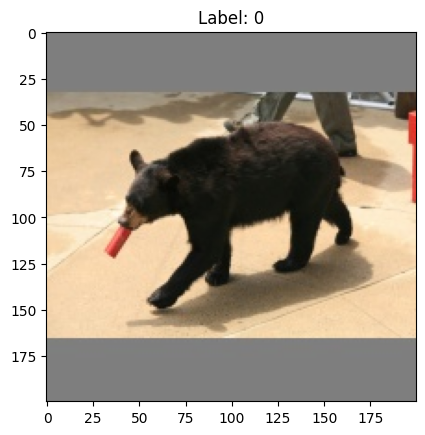

In [3]:
import numpy as np
import matplotlib.pyplot as plt

image, label = dataset_norm[0]

image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
mean=[0.5018, 0.4925, 0.4460]
std=[0.2339, 0.2276, 0.2402]
image = image * std + mean  # Denormalize
image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1

# Display the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

In [4]:
no_of_classes = len(dataset_norm.classes)
no_of_classes

81

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
# Splitting dataset into Train and Test

labels = dataset_norm.classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [22]:
# Split the dataset
from torch.utils.data import random_split

# Define sizes for train and test sets
total_size = len(dataset_norm)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size  # Remaining 80% for training

# Split the dataset
train_dataset, test_dataset = random_split(dataset_norm, [train_size, test_size])

In [24]:
from torch.utils.data import WeightedRandomSampler

# Extract labels for the training dataset
train_labels = [label for _, label in train_dataset]

# Create a list of sample weights based on class weights
train_sample_weights = [class_weights_tensor[label].item() for label in train_labels]

# Create the sampler
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=32)

## P2 - fine-tuning RESNET and saving result

In [26]:
# DO A FINE-TUNED RESNET
import torchvision.models as models
import torch.nn as nn
from torch.optim import Adam


# Load pre-trained ResNet model
resnet = models.resnet50(weights=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match number of classes
num_classes = no_of_classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes, device = device)

c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [11]:
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10 


for epoch in tqdm(range(num_epochs), desc="Optimizing: "):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # move to GPU if available
        
        optimizer.zero_grad() # Zero the parameter gradients
        
        # Forward pass
        outputs = resnet(inputs).to(device) # move to GPU if available
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Optimizing:  10%|█         | 1/10 [01:52<16:50, 112.33s/it]

Epoch [1/10], Loss: 0.5672


Optimizing:  20%|██        | 2/10 [03:41<14:43, 110.44s/it]

Epoch [2/10], Loss: 0.7453


Optimizing:  30%|███       | 3/10 [05:29<12:44, 109.23s/it]

Epoch [3/10], Loss: 0.3739


Optimizing:  40%|████      | 4/10 [07:13<10:44, 107.46s/it]

Epoch [4/10], Loss: 1.1361


Optimizing:  50%|█████     | 5/10 [08:58<08:52, 106.56s/it]

Epoch [5/10], Loss: 0.2091


Optimizing:  60%|██████    | 6/10 [10:40<06:59, 104.97s/it]

Epoch [6/10], Loss: 0.8246


Optimizing:  70%|███████   | 7/10 [12:21<05:11, 103.71s/it]

Epoch [7/10], Loss: 1.5560


Optimizing:  80%|████████  | 8/10 [14:03<03:25, 103.00s/it]

Epoch [8/10], Loss: 0.3968


Optimizing:  90%|█████████ | 9/10 [15:43<01:41, 101.97s/it]

Epoch [9/10], Loss: 0.6689


Optimizing: 100%|██████████| 10/10 [17:22<00:00, 104.26s/it]

Epoch [10/10], Loss: 0.9083


In [12]:
# Save the re-trained ResNet weights

# Save the model's state dictionary
torch.save(resnet.state_dict(), 'resnet50_state_dict_new.pth')

## P3 - Loading re-trained RESNET and testing

In [39]:
# Load the state dictionary later

# First, recreate the model architecture
resnet = models.resnet50(weights=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

num_classes = no_of_classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes, device = device)

# Then load the state dictionary
resnet.load_state_dict(torch.load('resnet50_state_dict_new.pth', map_location=device))

cuda


<All keys matched successfully>

In [28]:
# TESTING
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(data_loader, desc="Testing: "):
            inputs, labels = inputs.to(device), labels.to(device) # move to GPU if available
            outputs = model(inputs).to(device) # move to GPU if available
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return accuracy, precision, recall, f1

In [29]:
# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(resnet, test_loader)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Testing: 100%|██████████| 346/346 [01:14<00:00,  4.64it/s]

Accuracy: 0.8897038848139093
Precision: 0.8952987626130121
Recall: 0.8897038848139093
F1 Score: 0.8851183442592401



c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## P4 - test on new image

In [47]:
# Test the model on one image

from torchvision import transforms
from PIL import Image

# Load image
image_path = 'extra images test/horse.jpg' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size your model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

image = transform(image).unsqueeze(0)  # Add a batch dimension

In [46]:
resnet.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
# Move model to GPU
resnet = resnet.to('cuda' if torch.cuda.is_available() else 'cpu')
#resnet.eval()

In [49]:
import torch
import torch.nn.functional as F

with torch.no_grad():  # Disable gradient tracking
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = resnet(image)
    probabilities = F.softmax(outputs, dim=1)

In [50]:
# Get top categories
top_num = 5  # Number of top categories you want
top_prob, top_catid = torch.topk(probabilities, top_num)

# Convert category names
class_to_idx = dataset_norm.class_to_idx

# Get clas names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Convert to Python data types and print
top_prob = top_prob.cpu().numpy()[0]
top_catid = top_catid.cpu().numpy()[0]

for i in range(top_num):
    predicted_class_name = idx_to_class[top_catid[i]]
    print(f"Category ID: {predicted_class_name}, Probability: {top_prob[i]:.2f}")

Category ID: Horse, Probability: 0.98
Category ID: Dog, Probability: 0.02
Category ID: Giraffe, Probability: 0.00
Category ID: Cattle, Probability: 0.00
Category ID: Chicken, Probability: 0.00


In [ ]:
# files needed:
# resnet50_state_dict.pth

# **VIT SECTION**

## P1 - loading data

In [1]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

# Load dataset
#dataset_path = 'Test1_large/'
dataset_path = 'Data_small/'

# Определение трансформаций 
transform_norm_new = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = ImageFolder(dataset_path, transform=transform_norm_new)
no_of_classes = len(dataset_norm.classes)


# Split the dataset
from torch.utils.data import random_split

# Define sizes for train and test sets
total_size = len(dataset_norm)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size  # Remaining 80% for training

# Split the dataset
train_dataset_adj, test_dataset_adj = random_split(dataset_norm, [train_size, test_size])

# Save dataset_norm class names
class_to_idx = dataset_norm.class_to_idx

with open('class_to_idx.json', 'w') as f:
    json.dump(class_to_idx, f)

## P2 - fine-tuning the model and saving result

In [4]:
import timm
import torch.nn as nn
from torch.optim import Adam

model_names = timm.list_models('vit*', pretrained=True)
print(model_names)


# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check other models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


# Modify the final fully connected layer to match  number of classes
num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Only train the last layer
for param in model.head.parameters():
    param.requires_grad = True


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['vit_base_patch8_224.augreg2_in21k_ft_in1k', 'vit_base_patch8_224.augreg_in21k', 'vit_base_patch8_224.augreg_in21k_ft_in1k', 'vit_base_patch8_224.dino', 'vit_base_patch14_dinov2.lvd142m', 'vit_base_patch14_reg4_dinov2.lvd142m', 'vit_base_patch16_224.augreg2_in21k_ft_in1k', 'vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.augreg_in21k', 'vit_base_patch16_224.augreg_in21k_ft_in1k', 'vit_base_patch16_224.dino', 'vit_base_patch16_224.mae', 'vit_base_patch16_224.orig_in21k', 'vit_base_patch16_224.orig_in21k_ft_in1k', 'vit_base_patch16_224.sam_in1k', 'vit_base_patch16_224_miil.in21k', 'vit_base_patch16_224_miil.in21k_ft_in1k', 'vit_base_patch16_384.augreg_in1k', 'vit_base_patch16_384.augreg_in21k_ft_in1k', 'vit_base_patch16_384.orig_in21k_ft_in1k', 'vit_base_patch16_clip_224.datacompxl', 'vit_base_patch16_clip_224.dfn2b', 'vit_base_patch16_clip_224.laion2b', 'vit_base_patch16_clip_224.laion2b_ft_in1k', 'vit_base_patch16_clip_224.laion2b_ft_in12k', 'vit_base_patch16_clip_224.laion2b

In [43]:
# Reshape train_loader and test_loader to match dimensions required by the model (32, 8, 144, 144)

train_loader_adj = DataLoader(train_dataset_adj, batch_size=32, shuffle=False, num_workers=32)
test_loader_adj = DataLoader(test_dataset_adj, batch_size=32, shuffle=False, num_workers=32)

In [44]:
from tqdm import tqdm
import torch.nn as nn
from timm.optim import AdamP

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.head.parameters(), lr=0.001) # try AdamW

# Training loop
num_epochs = 10  # or any number of epochs you prefer

torch.set_grad_enabled(True) # testing!!!

for epoch in tqdm(range(num_epochs), desc="Optimizing: "):
    for inputs, labels in train_loader_adj:
        inputs, labels = inputs.to(device), labels.to(device) # move to GPU if available

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).to(device) # move to GPU if available
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing:  10%|█         | 1/10 [01:31<13:41, 91.31s/it]

Epoch [1/10], Loss: 0.6275


Optimizing:  20%|██        | 2/10 [03:03<12:12, 91.62s/it]

Epoch [2/10], Loss: 0.3591


Optimizing:  30%|███       | 3/10 [04:34<10:40, 91.57s/it]

Epoch [3/10], Loss: 0.2390


Optimizing:  40%|████      | 4/10 [06:05<09:07, 91.32s/it]

Epoch [4/10], Loss: 0.1739


Optimizing:  50%|█████     | 5/10 [07:36<07:36, 91.32s/it]

Epoch [5/10], Loss: 0.1243


Optimizing:  60%|██████    | 6/10 [09:08<06:05, 91.35s/it]

Epoch [6/10], Loss: 0.0873


Optimizing:  70%|███████   | 7/10 [10:39<04:34, 91.39s/it]

Epoch [7/10], Loss: 0.0670


Optimizing:  80%|████████  | 8/10 [12:11<03:03, 91.51s/it]

Epoch [8/10], Loss: 0.0543


Optimizing:  90%|█████████ | 9/10 [13:43<01:31, 91.69s/it]

Epoch [9/10], Loss: 0.0439


Optimizing: 100%|██████████| 10/10 [15:16<00:00, 91.61s/it]

Epoch [10/10], Loss: 0.0363


In [45]:
# Save the re-trained ResNet weights

# Save the model's state dictionary
torch.save(model.state_dict(), 'vit_base_patch32_state_dict.pth')

## P3 - Loading re-trained model and testing

In [5]:
# Load the state dictionary later

# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check others models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device)

# Then load the state dictionary
model.load_state_dict(torch.load('vit_base_patch32_state_dict.pth'))

cuda


<All keys matched successfully>

In [47]:
# TESTING
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(data_loader, desc="Testing: "):
            inputs, labels = inputs.to(device), labels.to(device) # move to GPU if available
            outputs = model(inputs).to(device) # move to GPU if available
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return accuracy, precision, recall, f1

In [48]:
# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader_adj)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Testing: 100%|██████████| 340/340 [01:07<00:00,  5.06it/s]

Accuracy: 0.8877551020408163
Precision: 0.8901725825488664
Recall: 0.8877551020408163
F1 Score: 0.8875943962517109


## P4 - test on new image

In [7]:
# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
#image_path = 'extra images test/shiba-inu.webp' # test image path
image_path = 'extra images test/animal3.webp' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size that model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

image = transform(image).unsqueeze(0)  # Add a batch dimension

import torch
import torch.nn.functional as F

with torch.no_grad():  # Disable gradient tracking
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)

# Get top categories
top_num = 5  # Number of top categories you want
top_prob, top_catid = torch.topk(probabilities, top_num)

# Load category names
with open('class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}


# Convert to Python data types and print
top_prob = top_prob.cpu().numpy()[0]
top_catid = top_catid.cpu().numpy()[0]

for i in range(top_num):
    predicted_class_name = idx_to_class[top_catid[i]]
    print(f"Category ID: {predicted_class_name}, Probability: {top_prob[i]:.2f}")

Category ID: Fox, Probability: 1.00
Category ID: Dog, Probability: 0.00
Category ID: Raccoon, Probability: 0.00
Category ID: Mouse, Probability: 0.00
Category ID: Lizard, Probability: 0.00


In [ ]:
# files needed:
# vit_base_patch32_state_dict.pth

# **RESNET + SVM / GB SECTION**

## P1 - Load data

In [1]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Load dataset
#dataset_path = 'Test1_large/'
dataset_path = 'Data_small/'

# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = ImageFolder(dataset_path, transform=transform_norm)


dataloader = DataLoader(dataset_norm, batch_size=32, shuffle=True, num_workers=32)


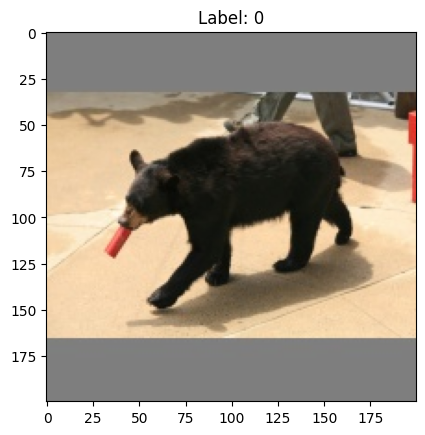

In [2]:
import numpy as np
import matplotlib.pyplot as plt

image, label = dataset_norm[0]

image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
mean=[0.5018, 0.4925, 0.4460]
std=[0.2339, 0.2276, 0.2402]
image = image * std + mean  # Denormalize
image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1

# Display the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

In [3]:
no_of_classes = len(dataset_norm.classes)
no_of_classes

81

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Splitting dataset into Train and Test

labels = dataset_norm.classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [6]:
# Split the dataset
from torch.utils.data import random_split

# Define sizes for train and test sets
total_size = len(dataset_norm)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size  # Remaining 80% for training

# Split the dataset
train_dataset, test_dataset = random_split(dataset_norm, [train_size, test_size])

In [7]:
from torch.utils.data import WeightedRandomSampler

# Extract labels for the training dataset
train_labels = [label for _, label in train_dataset]

# Create a list of sample weights based on class weights
train_sample_weights = [class_weights_tensor[label].item() for label in train_labels]

# Create the sampler
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=32)

## P2 - Extract features from RESNET

In [15]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Load dataset
#dataset_path = 'Test1_large/'
dataset_path = 'Data_small/'

# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = ImageFolder(dataset_path, transform=transform_norm)


dataloader = DataLoader(dataset_norm, batch_size=32, shuffle=True, num_workers=32)

In [95]:
# Load RESNET weights and extract features

import torchvision.models as models
import torch.nn as nn
import torch

# Load pre-trained ResNet model
resnet = models.resnet50(weights=None)  # Load without default pre-trained weights

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Update the fully connected layer to match the number of classes you have
num_classes = no_of_classes 
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)

# Load the state dictionary with your trained weights
resnet.load_state_dict(torch.load('resnet50_state_dict_new.pth', map_location=device))

feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)

# Feature extraction process
import numpy as np
from tqdm import tqdm

final_features = []
final_labels = []

for inputs, labels in tqdm(dataloader, desc="Extracting Features: "):
    inputs = inputs.to(device)
    
    with torch.no_grad():  # No gradient needed for feature extraction
        # Extract features
        features = feature_extractor(inputs)
        features = torch.flatten(features, start_dim=1)  # Flatten the features
        final_features.append(features.cpu().numpy())
        final_labels.append(labels.numpy())

final_features = np.concatenate(final_features, axis=0)
final_labels = np.concatenate(final_labels, axis=0)

Extracting Features: 100%|██████████| 1726/1726 [01:43<00:00, 16.67it/s]


In [96]:
#final_features = final_features.mean(axis=1)  # Shape: (54391, 768)
#final_features.shape
import pandas as pd

# Convert to DataFrame and save to CSV
df_features = pd.DataFrame(final_features)
df_features['label'] = final_labels
df_features.to_csv('resnet_features.csv', index=False)

## P3 - Train SVM on RESNET features

### P3A - Train SVM

In [ ]:
# Load the state dictionary later
import timm
import torch.nn as nn
import torch

# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check others models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

no_of_classes = 81

num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device)

# Then load the state dictionary
model.load_state_dict(torch.load('vit_base_patch32_state_dict.pth'))

cuda


<All keys matched successfully>

In [ ]:
# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
#image_path = 'extra images test/shiba-inu.webp' # test image path
image_path = 'extra images test/animal3.webp' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size that model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

image = transform(image).unsqueeze(0)  # Add a batch dimension
image = image.to(device)

from torch.utils.data import DataLoader

batch_size = 32 
data_loader = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False, num_workers=1)

# Extract features
final_features = []
final_labels = []
with torch.no_grad():  # No gradient needed for feature extraction
    features = model.forward_features(image)
    features = features.cpu().numpy()

features = features.mean(axis=1)  # Shape: (1, 768)

cuda


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('resnet_features.csv')
#df = pd.read_csv('extracted_features_resnet2.csv')
X = df.drop('label', axis=1).values  # Features
y = df['label'].values  # Labels

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# TRAIN SVM

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline that includes scaling and the SVM
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Train the SVM
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_pipeline.score(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 89.46%


In [31]:
import pickle

# Save the model to disk
model_filename = 'resnet_svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_pipeline, file)

### P3B - Infer an image

In [5]:
import os
import pickle
file_name = 'resnet_svm_model.pkl'
model_folder = 'models'
model_path = os.path.join(model_folder, file_name)

with open(model_path, 'rb') as file:
    svm_pipeline = pickle.load(file)

In [34]:
# Load the state dictionary later

# First, recreate the model architecture
resnet = models.resnet50(weights=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

no_of_classes = 81
num_classes = no_of_classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)

# Then load the state dictionary
resnet.load_state_dict(torch.load('resnet50_state_dict_new.pth', map_location=device))


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


<All keys matched successfully>

In [103]:
# Inference new image

# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
image_path = 'Deer.jpg'
image = Image.open(image_path)

# Определение трансформаций 
transform_norm = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

image = transform_norm(image).unsqueeze(0)  # Add a batch dimension
image = image.to(device)


feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

# Feature extraction process
import numpy as np
from tqdm import tqdm

final_features = []
    
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(image)
    features = torch.flatten(features, start_dim=1)  # Flatten the features
    final_features.append(features.cpu().numpy())
    #features = features.cpu().numpy()

final_features = np.concatenate(final_features, axis=0)

print(final_features.shape)
features = final_features

cuda
(1, 2048)


In [104]:
import pickle

# Load the trained SVM model from the pickle file
with open('resnet_svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

# Load category names
with open('class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Make predictions
prediction = svm_model.predict(features)
predicted_class_name = idx_to_class[prediction[0]]
print(predicted_class_name)

Deer
[13]


## P4 - Train XGB on RESNET features

### P4A - Train XGB

In [94]:
import xgboost as xgb


params = {
    'objective': 'multi:softprob',  # Use 'multi:softprob' for probability predictions
    'num_class': len(set(final_labels)),  # Set to the number of classes
    'device': 'cuda', 
    'eval_metric': 'mlogloss',  # Multiclass log loss
    'learning_rate': 0.1,
}

In [95]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create DMatrix for training and validation sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [96]:
num_round = 100  # Number of boosting rounds

eval_set = [(dtrain, 'train'), (dvalid, 'valid')]
bst = xgb.train(params, dtrain, num_boost_round=num_round, evals=eval_set, early_stopping_rounds=10, verbose_eval=True)

[0]	train-mlogloss:2.13600	valid-mlogloss:2.24413
[1]	train-mlogloss:1.86759	valid-mlogloss:2.02867
[2]	train-mlogloss:1.66847	valid-mlogloss:1.87084
[3]	train-mlogloss:1.50672	valid-mlogloss:1.74319
[4]	train-mlogloss:1.37110	valid-mlogloss:1.63704
[5]	train-mlogloss:1.25391	valid-mlogloss:1.54486
[6]	train-mlogloss:1.15222	valid-mlogloss:1.46533
[7]	train-mlogloss:1.06157	valid-mlogloss:1.39431
[8]	train-mlogloss:0.97998	valid-mlogloss:1.33147
[9]	train-mlogloss:0.90746	valid-mlogloss:1.27559
[10]	train-mlogloss:0.84153	valid-mlogloss:1.22438
[11]	train-mlogloss:0.78170	valid-mlogloss:1.17880
[12]	train-mlogloss:0.72700	valid-mlogloss:1.13694
[13]	train-mlogloss:0.67625	valid-mlogloss:1.09845
[14]	train-mlogloss:0.63019	valid-mlogloss:1.06286
[15]	train-mlogloss:0.58815	valid-mlogloss:1.03073
[16]	train-mlogloss:0.54873	valid-mlogloss:1.00074
[17]	train-mlogloss:0.51243	valid-mlogloss:0.97380
[18]	train-mlogloss:0.47906	valid-mlogloss:0.94853
[19]	train-mlogloss:0.44830	valid-mloglos

In [97]:
import pickle

# Save the model to disk
with open('resnet_XGB_model.pkl', 'wb') as file:
    pickle.dump(bst, file)

In [99]:
# Calculate accuracy

import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score

filename = 'resnet_XGB_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

dtest = xgb.DMatrix(X_test, label=y_test)
predictions = loaded_model.predict(dtest)

# Convert probabilities to hard predictions
hard_predictions = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, hard_predictions)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 84.54%


In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('features_labels_resnet.csv')
X = df.drop('label', axis=1).values  # Features
y = df['label'].values  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
import optuna
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split


def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    
    param = {
        'verbosity': 0,  # Silence the output
        'objective': 'multi:softprob',
        'num_class': 81,
        'tree_method': 'gpu_hist',  # Use GPU
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = xgb.train(param, dtrain)
    preds = model.predict(dvalid)
    pred_labels = np.argmax(preds, axis=1)
    loss = log_loss(y_test, preds)
    return loss

In [75]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-20 00:23:14,430] A new study created in memory with name: no-name-ca357363-9cdb-49ed-8ce7-fe48c2328353
[I 2024-02-20 00:23:17,973] Trial 0 finished with value: 3.3960643784145246 and parameters: {'lambda': 8.700210853205523e-08, 'alpha': 0.0009686841123719618, 'colsample_bytree': 0.6020613740261089, 'subsample': 0.43988908098252627, 'learning_rate': 0.06995831482471378, 'n_estimators': 729, 'max_depth': 9, 'min_child_weight': 227}. Best is trial 0 with value: 3.3960643784145246.
[I 2024-02-20 00:23:21,156] Trial 1 finished with value: 3.206384404005623 and parameters: {'lambda': 1.486072769568247e-06, 'alpha': 1.2599372062121187e-06, 'colsample_bytree': 0.2766218361068883, 'subsample': 0.4102598021854622, 'learning_rate': 0.1556341659796527, 'n_estimators': 934, 'max_depth': 9, 'min_child_weight': 297}. Best is trial 1 with value: 3.206384404005623.
[I 2024-02-20 00:23:26,680] Trial 2 finished with value: 1.943235891039775 and parameters: {'lambda': 0.01673844531152697, 'alp

Number of finished trials: 100
Best trial: {'lambda': 1.5912389259861638e-06, 'alpha': 0.00022314831029604117, 'colsample_bytree': 0.9919493851175465, 'subsample': 0.8280763536915137, 'learning_rate': 0.25899984999690945, 'n_estimators': 844, 'max_depth': 9, 'min_child_weight': 8}


In [77]:
best_params = study.best_trial.params
print("Best trial hyperparameters: ", best_params)

fixed_params = {
    'objective': 'multi:softprob',
    'num_class': 81, 
    'tree_method': 'gpu_hist'
}

best_params.update(fixed_params)
best_model = xgb.train(best_params, dtrain, num_boost_round=study.best_trial.user_attrs.get("best_num_boost_round", 100))


Best trial hyperparameters:  {'lambda': 1.5912389259861638e-06, 'alpha': 0.00022314831029604117, 'colsample_bytree': 0.9919493851175465, 'subsample': 0.8280763536915137, 'learning_rate': 0.25899984999690945, 'n_estimators': 844, 'max_depth': 9, 'min_child_weight': 8}


In [78]:
import pickle

# Save the model to disk
with open('resnet_XGB_model_optuna.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [80]:
# Calculate accuracy

import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

filename = 'resnet_XGB_model_optuna.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

dtest = xgb.DMatrix(X_test, label=y_test)
predictions = loaded_model.predict(dtest)

# Convert probabilities to hard predictions
hard_predictions = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, hard_predictions)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 84.29%


### P4B - Infer an image

In [112]:
# Inference new image

# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
image_path = 'Deer.jpg' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size that model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

image = transform(image).unsqueeze(0)  # Add a batch dimension
image = image.to(device)
#dataset_norm = ImageFolder(image_path, transform=transform)


from torch.utils.data import DataLoader

batch_size = 32 
data_loader = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False, num_workers=1)


feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)

# Feature extraction process
import numpy as np
from tqdm import tqdm

final_features = []
    
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(image)
    features = torch.flatten(features, start_dim=1)  # Flatten the features
    features = features.cpu().numpy()

cuda


In [113]:
# XGB

import pickle
import xgboost as xgb
import numpy as np

filename = 'resnet_XGB_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Load category names
with open('class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}

dnew = xgb.DMatrix(features)
predictions = loaded_model.predict(dnew)

top_num = 5
top5_indices = np.argsort(predictions, axis=1)[:, -top_num:]

top5_probs = np.array([sample[indices] for sample, indices in zip(predictions, top5_indices)])


predictions = []
for i in range(top_num):
    class_index = top5_indices[0, -i]
    predicted_class_name = idx_to_class[class_index]
    predicted_probability = top5_probs[0, -i]
    predictions.append({'Category ID': predicted_class_name, 'Probability': predicted_probability})

df = pd.DataFrame(predictions)
df.sort_values(by='Probability', ascending=False, inplace=True)
df_string = df.to_string(index=False)
print(df_string)

Category ID  Probability
       Deer     0.996309
       Goat     0.001692
        Fox     0.000275
   Kangaroo     0.000212
      Sheep     0.000162


# **VIT + SVM / XGB SECTION**

## P1 - Load data

In [1]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

# Load dataset
dataset_path = 'Data_small/'

# Определение трансформаций 
transform_norm_new = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], # Наши подсчитанные значения mean и std для нормализации
                         std=[0.2339, 0.2276, 0.2402])
])

dataset_norm = ImageFolder(dataset_path, transform=transform_norm_new)
no_of_classes = len(dataset_norm.classes)


# Split the dataset
from torch.utils.data import random_split

# Define sizes for train and test sets
total_size = len(dataset_norm)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size  # Remaining 80% for training

# Split the dataset
train_dataset_adj, test_dataset_adj = random_split(dataset_norm, [train_size, test_size])

# Save dataset_norm class names
class_to_idx = dataset_norm.class_to_idx

with open('class_to_idx.json', 'w') as f:
    json.dump(class_to_idx, f)

## P2 - Extract features from VIT

In [2]:
import timm
import torch.nn as nn
from torch.optim import Adam

model_names = timm.list_models('vit*', pretrained=True)
print(model_names)


# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check other models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


# Modify the final fully connected layer to match  number of classes
num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device) # as before

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Only train the last layer
for param in model.head.parameters():
    param.requires_grad = True


c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['vit_base_patch8_224.augreg2_in21k_ft_in1k', 'vit_base_patch8_224.augreg_in21k', 'vit_base_patch8_224.augreg_in21k_ft_in1k', 'vit_base_patch8_224.dino', 'vit_base_patch14_dinov2.lvd142m', 'vit_base_patch14_reg4_dinov2.lvd142m', 'vit_base_patch16_224.augreg2_in21k_ft_in1k', 'vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.augreg_in21k', 'vit_base_patch16_224.augreg_in21k_ft_in1k', 'vit_base_patch16_224.dino', 'vit_base_patch16_224.mae', 'vit_base_patch16_224.orig_in21k', 'vit_base_patch16_224.orig_in21k_ft_in1k', 'vit_base_patch16_224.sam_in1k', 'vit_base_patch16_224_miil.in21k', 'vit_base_patch16_224_miil.in21k_ft_in1k', 'vit_base_patch16_384.augreg_in1k', 'vit_base_patch16_384.augreg_in21k_ft_in1k', 'vit_base_patch16_384.orig_in21k_ft_in1k', 'vit_base_patch16_clip_224.datacompxl', 'vit_base_patch16_clip_224.dfn2b', 'vit_base_patch16_clip_224.laion2b', 'vit_base_patch16_clip_224.laion2b_ft_in1k', 'vit_base_patch16_clip_224.laion2b_ft_in12k', 'vit_base_patch16_clip_224.laion2b

In [16]:
# Reshape train_loader and test_loader to match dimensions required by the model (32, 8, 144, 144)

train_loader_adj = DataLoader(train_dataset_adj, batch_size=32, shuffle=False, num_workers=32)
test_loader_adj = DataLoader(test_dataset_adj, batch_size=32, shuffle=False, num_workers=32)

In [75]:
from torch.utils.data import DataLoader

batch_size = 32 
data_loader = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False, num_workers=16)

# Extract features
final_features = []
final_labels = []
with torch.no_grad():  # No gradient needed for feature extraction
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        features = model.forward_features(inputs)
        final_features.append(features.cpu().numpy())
        final_labels.append(labels.numpy())

final_features = np.concatenate(final_features, axis=0)
final_labels = np.concatenate(final_labels, axis=0)

In [76]:
final_features = final_features.mean(axis=1)  # Shape: (54391, 768)
final_features.shape

(54391, 768)

In [77]:
import pandas as pd

# Convert to DataFrame and save to CSV
df_features = pd.DataFrame(final_features)
df_features['label'] = final_labels
df_features.to_csv('vit_features.csv', index=False)

## P3 - Train SVM on VIT features

### P3A - Train SVM

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('vit_features.csv')
X = df.drop('label', axis=1).values  # Features
y = df['label'].values  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# TRAIN SVM

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_pipeline.fit(X_train, y_train)

accuracy = svm_pipeline.score(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 87.18%


In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    'svc__C': [0.1, 1, 100],
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],  # Including various kernel types
    'svc__gamma': [1e-3, 'scale', 'auto'],  # Relevant for 'rbf', 'poly', and 'sigmoid'
}

# Create a pipeline
pipeline = make_pipeline(StandardScaler(), SVC())

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1_weighted', n_jobs=-1, verbose=3, cv=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model found by the grid search on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_f1_score = f1_score(y_test, test_predictions, average='weighted') 
print(f"Test F1 Score (weighted): {test_f1_score:.2f}")

# Best parameters: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation score: 0.87
Test F1 Score (macro): 0.88


In [99]:
# Define the parameter grid to search, including various kernel types
param_grid = {
    'svc__C': [100, 1000, 10000],
    'svc__kernel': ['rbf'],  # Including various kernel types
    'svc__gamma': [1e-4, 1e-3, 1e-1],  # Relevant for 'rbf', 'poly', and 'sigmoid'
}

# Create a pipeline
pipeline = make_pipeline(StandardScaler(), SVC())

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1_weighted', n_jobs=-1, verbose=3, cv=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model found by the grid search on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_f1_score = f1_score(y_test, test_predictions, average='weighted') 
print(f"Test F1 Score (macro): {test_f1_score:.2f}")

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best parameters: {'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation score: 0.87
Test F1 Score (macro): 0.88


In [83]:
'''
import optuna
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def objective(trial):
    # Suggest values for the hyperparameters
    C = trial.suggest_float('svc__C', 0.1, 1000, log=True)
    kernel = trial.suggest_categorical('svc__kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    gamma = trial.suggest_categorical('svc__gamma', [1e-3, 1e-4, 'scale', 'auto'])

    # For 'poly' kernel, suggest degree. Otherwise, degree won't affect the model.
    if kernel == 'poly':
        degree = trial.suggest_int('svc__degree', 2, 4)
    else:
        degree = 3  # Default value

    # Create and train the SVM
    clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=kernel, gamma=gamma, degree=degree))
    # Use cross-validation to evaluate the model
    scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    
    # Optuna aims to maximize the objective, so return the mean accuracy
    return np.mean(scores)

# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can change n_trials to control the number of iterations

# Best trial
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
'''

[I 2024-02-28 22:42:34,294] A new study created in memory with name: no-name-55fbe6e2-385f-4bff-a0b7-337fd8b98726
[I 2024-02-28 22:45:33,979] Trial 0 finished with value: 0.8707023414444857 and parameters: {'svc__C': 342.25548010854976, 'svc__kernel': 'linear', 'svc__gamma': 0.0001}. Best is trial 0 with value: 0.8707023414444857.
[I 2024-02-28 22:48:33,784] Trial 1 finished with value: 0.8707023414444857 and parameters: {'svc__C': 91.9458944566866, 'svc__kernel': 'linear', 'svc__gamma': 'scale'}. Best is trial 0 with value: 0.8707023414444857.
[W 2024-02-28 22:55:03,080] Trial 2 failed with parameters: {'svc__C': 0.2603729780946754, 'svc__kernel': 'poly', 'svc__gamma': 'scale', 'svc__degree': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:

KeyboardInterrupt: 

In [81]:
import pickle

# Save the model to disk
model_filename = 'vit_svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_pipeline, file)

### P3B - Infer an image

In [105]:
# Load the state dictionary later
import timm
import torch.nn as nn
import torch

# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check others models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

no_of_classes = 81

num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device)

# Then load the state dictionary
model.load_state_dict(torch.load('vit_base_patch32_state_dict.pth'))

c:\VS Code\Project\movs_classification_2023\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


<All keys matched successfully>

In [106]:
# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
image_path = 'Deer.jpg' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size that model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

image = transform(image).unsqueeze(0)  # Add a batch dimension
image = image.to(device)
#dataset_norm = ImageFolder(image_path, transform=transform)


from torch.utils.data import DataLoader

batch_size = 32 
data_loader = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False, num_workers=1)

# Extract features
final_features = []
final_labels = []
with torch.no_grad():  # No gradient needed for feature extraction
    features = model.forward_features(image)
    features = features.cpu().numpy()

features = features.mean(axis=1)  # Shape: (1, 768)

cuda


In [107]:
import pickle

# Load the trained SVM model from the pickle file
with open('vit_svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

# Load category names
with open('class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Make predictions
prediction = svm_model.predict(features)
predicted_class_name = idx_to_class[prediction[0]]
print(predicted_class_name)

Deer


## P4 - Train XGB on VIT features

### P4A - Train XGB

In [34]:
import xgboost as xgb

params = {
    #'objective': 'multi:softmax',  # Use 'multi:softprob' for probability predictions
    'objective': 'multi:softprob',
    #'num_class': len(set(final_labels)),  # Set to the number of classes
    'num_class': 81,  # Set to the number of classes
    'device': 'cuda',  # Use GPU acceleration # to replace with 'device' = 'CUDA' for GPU
    'eval_metric': 'mlogloss',  # Multiclass log loss
    'learning_rate': 0.05
}

In [32]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create DMatrix for training and validation sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [36]:
num_round = 100  # Number of boosting rounds (shall be 1000)

eval_set = [(dtrain, 'train'), (dvalid, 'valid')]
bst = xgb.train(params, dtrain, num_boost_round=num_round, evals=eval_set, early_stopping_rounds=20, verbose_eval=True)

[0]	train-mlogloss:3.45468	valid-mlogloss:3.53383
[1]	train-mlogloss:3.10848	valid-mlogloss:3.24175
[2]	train-mlogloss:2.85210	valid-mlogloss:3.02984
[3]	train-mlogloss:2.64525	valid-mlogloss:2.86034
[4]	train-mlogloss:2.47197	valid-mlogloss:2.72040
[5]	train-mlogloss:2.32261	valid-mlogloss:2.60146
[6]	train-mlogloss:2.19079	valid-mlogloss:2.49681
[7]	train-mlogloss:2.07353	valid-mlogloss:2.40434
[8]	train-mlogloss:1.96713	valid-mlogloss:2.32052
[9]	train-mlogloss:1.87067	valid-mlogloss:2.24426
[10]	train-mlogloss:1.78164	valid-mlogloss:2.17493
[11]	train-mlogloss:1.69950	valid-mlogloss:2.11097
[12]	train-mlogloss:1.62353	valid-mlogloss:2.05226
[13]	train-mlogloss:1.55297	valid-mlogloss:1.99766
[14]	train-mlogloss:1.48668	valid-mlogloss:1.94601
[15]	train-mlogloss:1.42446	valid-mlogloss:1.89734
[16]	train-mlogloss:1.36597	valid-mlogloss:1.85166
[17]	train-mlogloss:1.31091	valid-mlogloss:1.80887
[18]	train-mlogloss:1.25888	valid-mlogloss:1.76804
[19]	train-mlogloss:1.20998	valid-mloglos

In [100]:
# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# f1 = f1_score(y_test, predictions, average='weighted')
# print(f"F1 Score: {f1:.2f}")

F1 Score: 0.81


In [37]:
import pickle

# Save the model to disk
with open('vit_XGB_model.pkl', 'wb') as file:
    pickle.dump(bst, file)

In [129]:
# Calculate accuracy

import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

filename = 'vit_XGB_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

dtest = xgb.DMatrix(X_test, label=y_test)
predictions = loaded_model.predict(dtest)

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')


print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test f1 score: {f1*100:.2f}%")

# 0.05: 82.66%
# 0.1: 82.39%
# 0.01: 80.02%


Test Accuracy: 82.23%
Test f1 score: 81.21%


### P4B - Infer image

In [108]:
# Load the state dictionary later
import timm
import torch.nn as nn
import torch

# Load pre-trained ResNet model
model = timm.create_model('vit_base_patch32_clip_224.openai_ft_in1k', pretrained=True) # to check others models as well

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

no_of_classes = 81

num_classes = no_of_classes
model.head = nn.Linear(model.head.in_features, num_classes, device = device)

# Then load the state dictionary
model.load_state_dict(torch.load('vit_base_patch32_state_dict.pth'))

cuda


<All keys matched successfully>

In [109]:
# Test the model on one image

from torchvision import transforms
from PIL import Image
import json

# Load image
image_path = 'Deer.jpg' # test image path
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size that model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5018, 0.4925, 0.4460], std=[0.2339, 0.2276, 0.2402]),  # Normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json

image = transform(image).unsqueeze(0)  # Add a batch dimension
image = image.to(device)
#dataset_norm = ImageFolder(image_path, transform=transform)


from torch.utils.data import DataLoader

batch_size = 32 
data_loader = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False, num_workers=1)

# Extract features
final_features = []
final_labels = []
with torch.no_grad():  # No gradient needed for feature extraction
    features = model.forward_features(image)
    features = features.cpu().numpy()

features = features.mean(axis=1)  # Shape: (1, 768)

cuda


In [111]:
# XGB

import pickle
import xgboost as xgb
import numpy as np

filename = 'vit_XGB_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Load category names
with open('class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names for prediction index
idx_to_class = {v: k for k, v in class_to_idx.items()}

dnew = xgb.DMatrix(features)
predictions = loaded_model.predict(dnew)

top_num = 5
top5_indices = np.argsort(predictions, axis=1)[:, -top_num:]

top5_probs = np.array([sample[indices] for sample, indices in zip(predictions, top5_indices)])


predictions = []
for i in range(top_num):
    class_index = top5_indices[0, -i]
    predicted_class_name = idx_to_class[class_index]
    predicted_probability = top5_probs[0, -i]
    predictions.append({'Category ID': predicted_class_name, 'Probability': predicted_probability})

df = pd.DataFrame(predictions)
df.sort_values(by='Probability', ascending=False, inplace=True)
df_string = df.to_string(index=False)
print(df_string)

Category ID  Probability
       Deer     0.305953
    Sparrow     0.203583
        Dog     0.067414
       Goat     0.058203
        Owl     0.015971
